In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def load_mcmc_intertwiners(mcmc_files):
    intertwiners = []
    for file in mcmc_files:
        df = pd.read_csv(file)
        intertwiners.append(df.loc[df.index.repeat(df.multiplicity)].iloc[:, :-1].to_numpy())
    return np.stack(intertwiners)

def load_gfn_intertwiners(gfn_files):
    return np.stack([pd.read_csv(f).to_numpy() for f in gfn_files])

def calculate_mean_cosine_dihedral_angle(intertwiners, spin):
    cos_angles = intertwiners*(intertwiners+1)/(2*spin*(spin+1)) - 1
    return cos_angles.mean(axis=1)[:, 0]
#     return cos_angles.mean(axis=(1, 2))


def get_empirical_distributions(intertwiners, spin_j):
    _, n_samples, grid_dim = intertwiners.shape
    grid_len = int(2*spin_j + 1)

    empirical_distributions = []
    for inds in intertwiners:
        counts = np.zeros(shape=(grid_len, )*grid_dim)
        np.add.at(counts, tuple(inds.T), 1)
        empirical_distributions.append(counts/n_samples)
        
    return np.stack(empirical_distributions)

def get_l1_distribution_error(intertwiners, spin_j, expected_distribution):
    distributions = get_empirical_distributions(intertwiners, spin_j)
    l1_errors = np.abs(distributions - expected_distribution)
    mean_errors = np.mean(l1_errors, axis=tuple(range(1, l1_errors.ndim)))
    return mean_errors

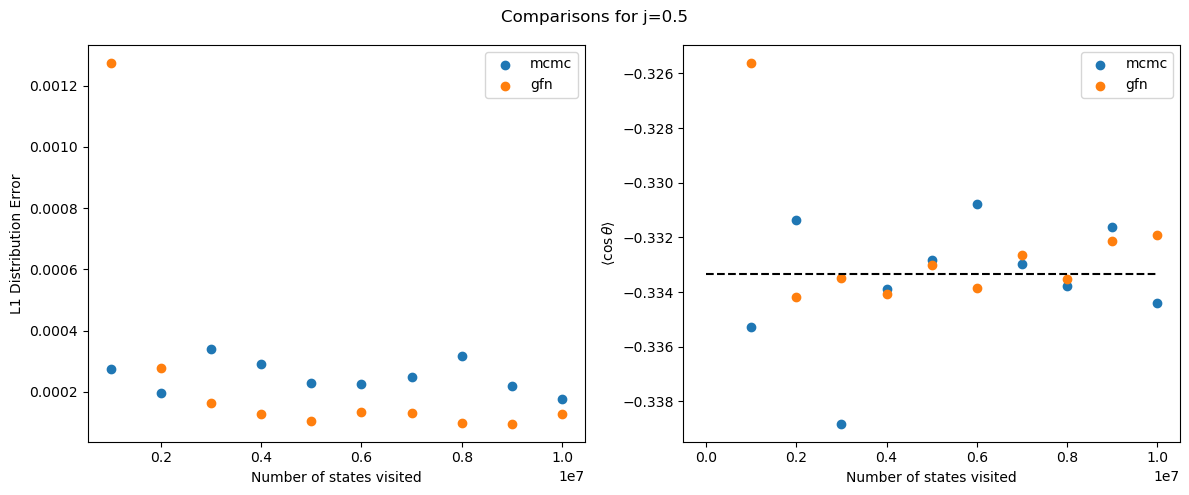

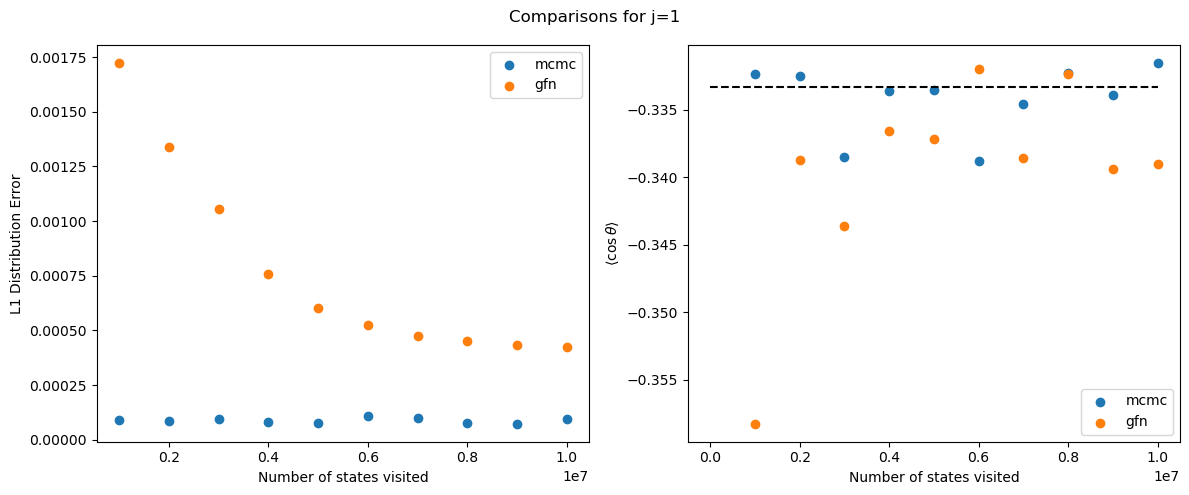

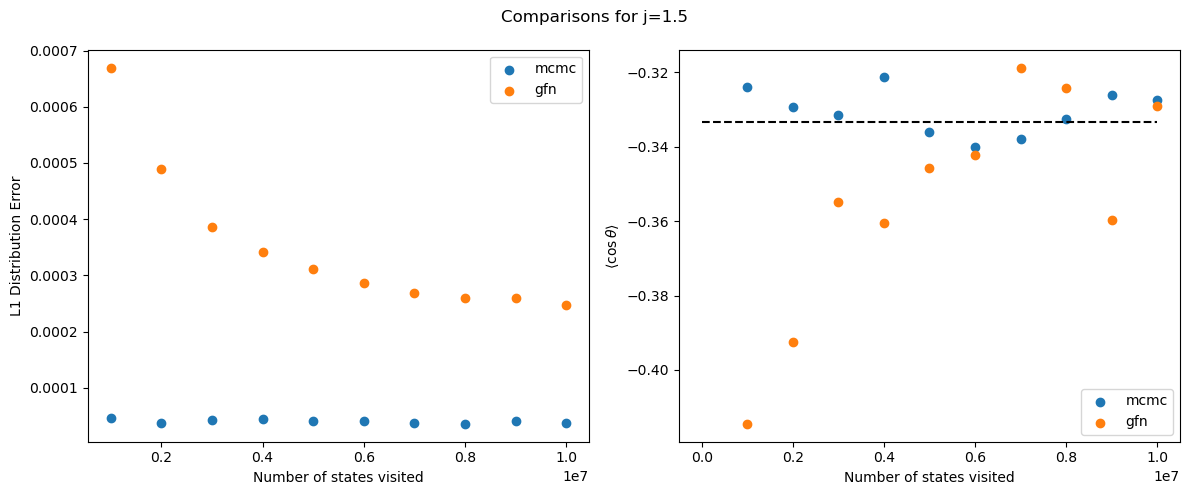

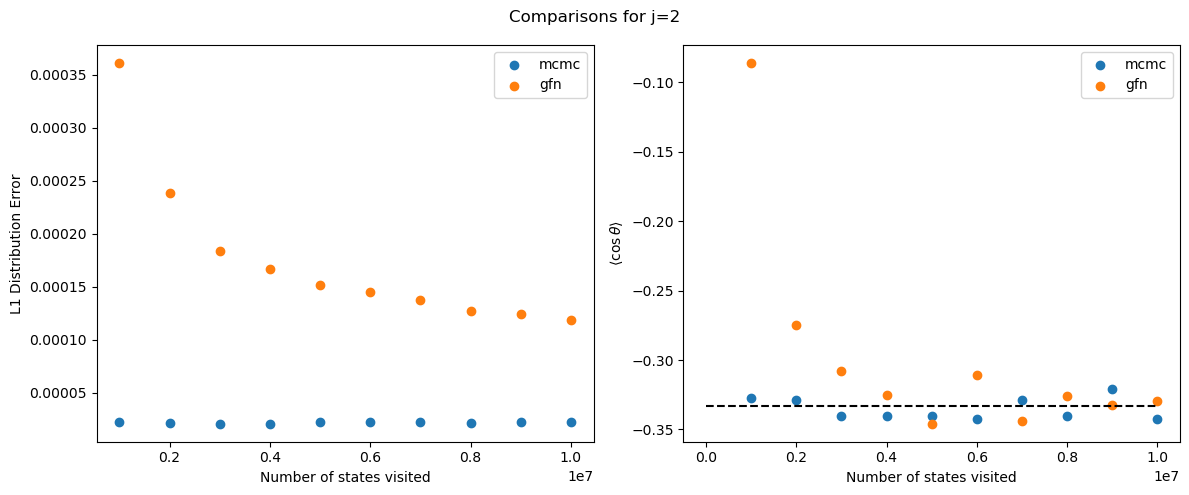

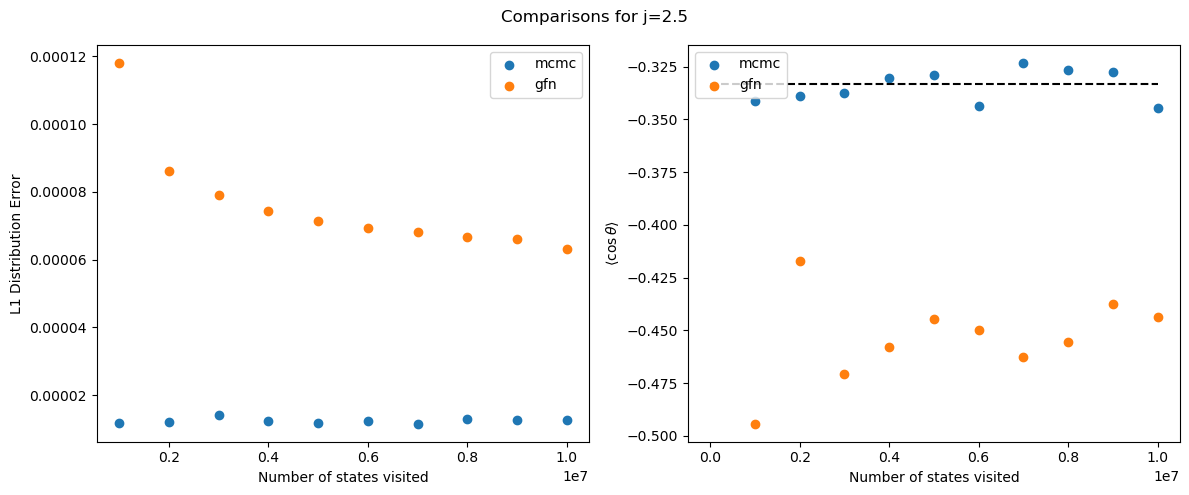

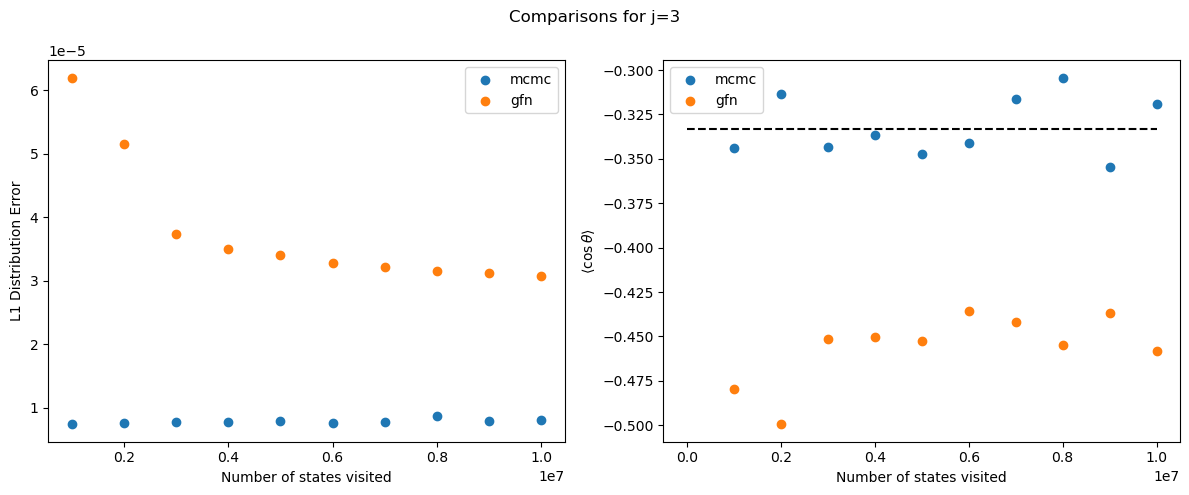

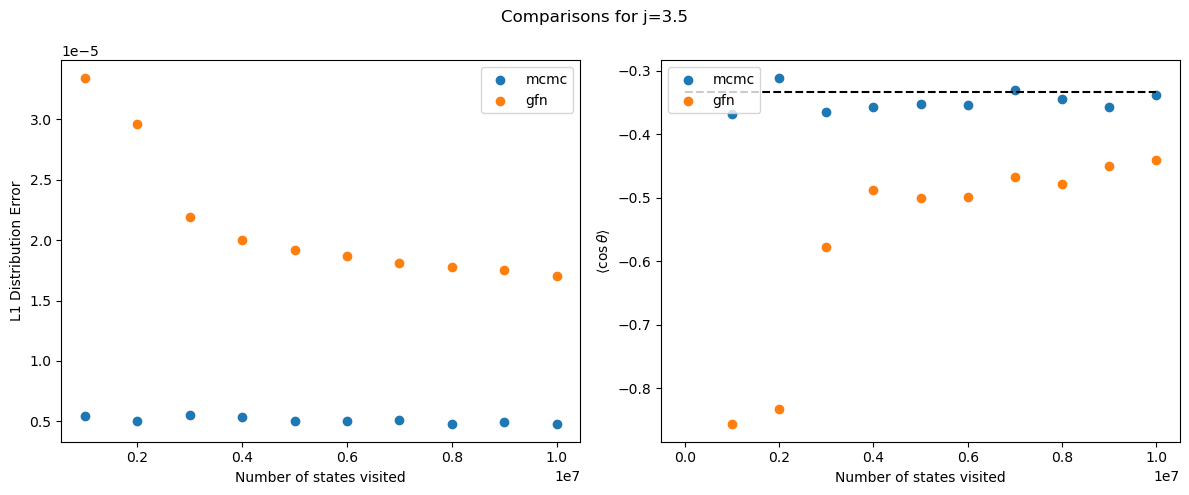

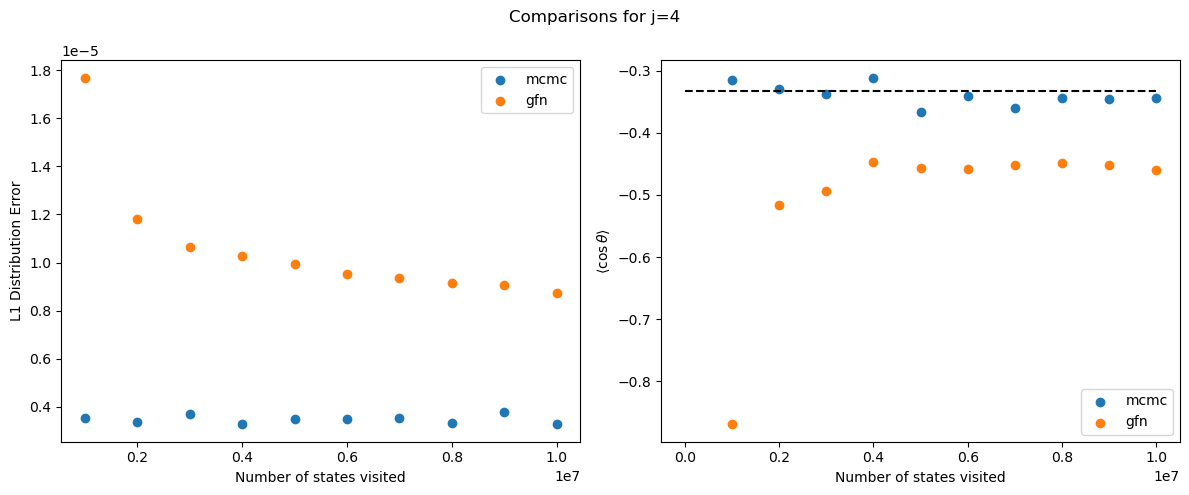

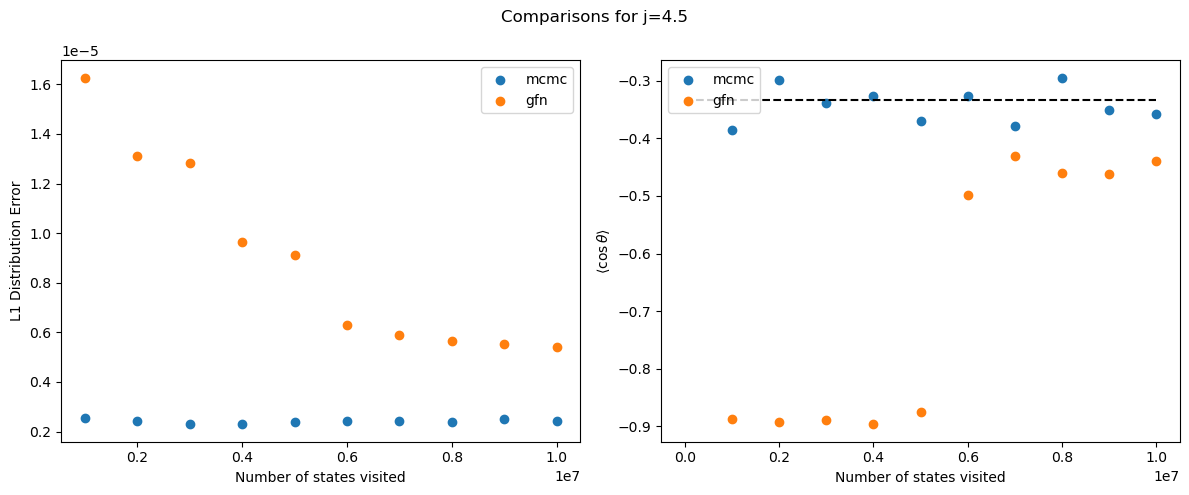

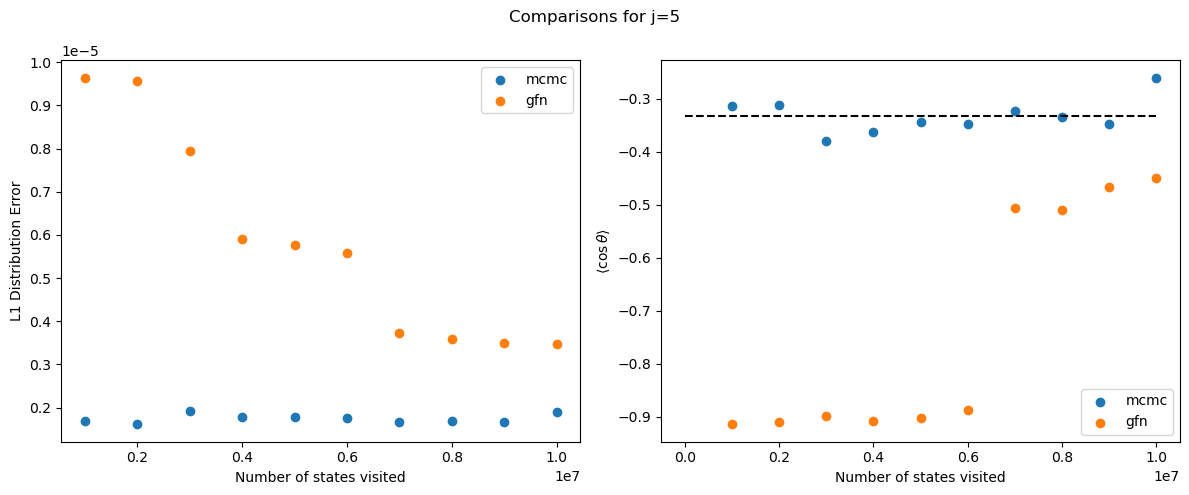

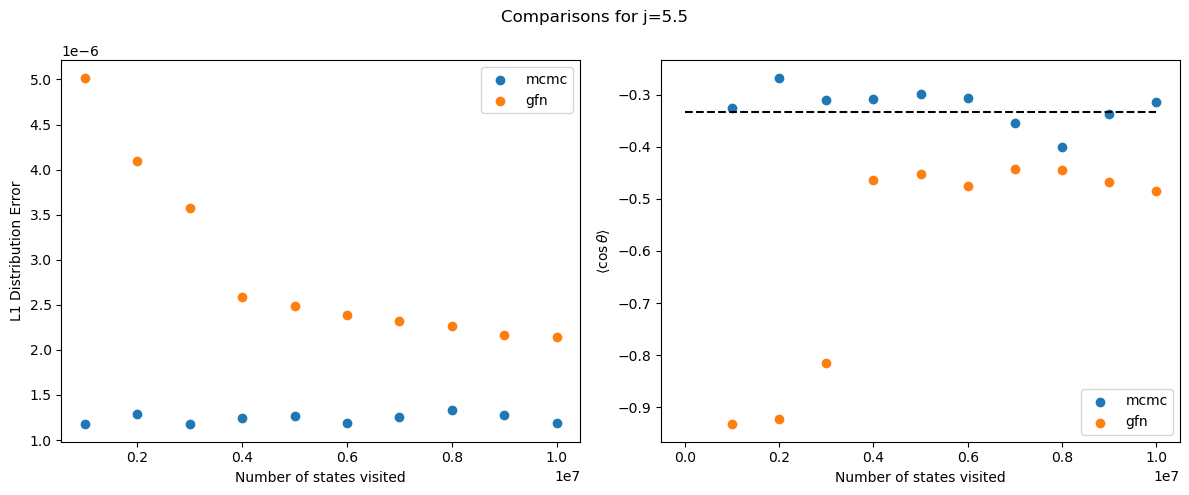

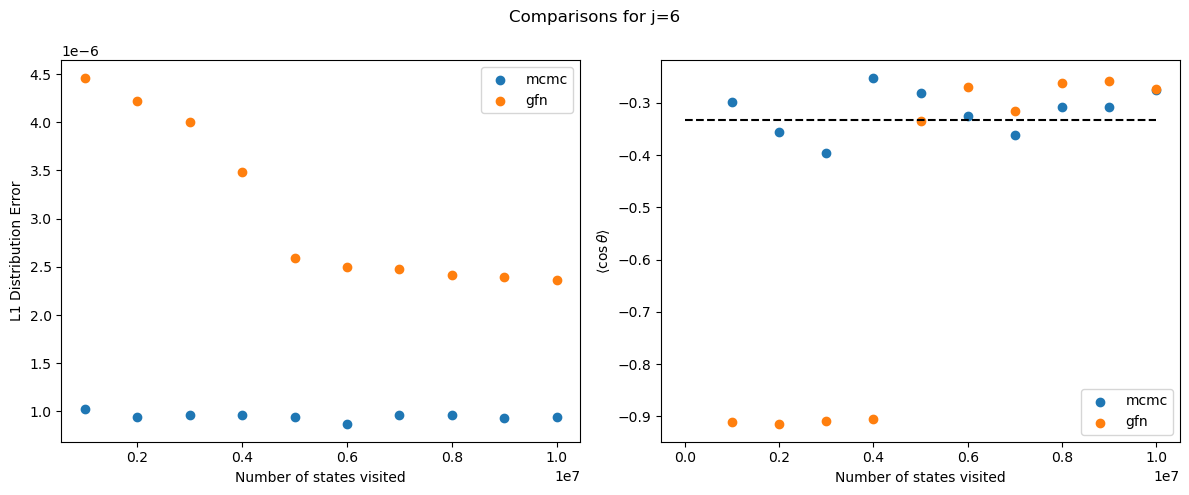

In [2]:
spin_js = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]

for spin_j in spin_js:
    # only one run for each
    mcmc_files = sorted(
        glob.glob(f"./data/MCMC/*/j_{float(spin_j)}/draws/draws_*.csv"), 
        key=lambda x: int(x.split(".")[-2].split("_")[-1])
    )

    gfn_files = sorted(
        glob.glob(f"./generated_samples_during_training/single_vertex_model/j={spin_j}/*/samples/*"),
        key=lambda x: int(x.split(".")[-2].split("_")[-3])
    )
    vertex = np.load(f"./data/EPRL_vertices/Python/Dl_20/vertex_j_{float(spin_j)}.npz")
    sq_amplitude = vertex**2
    expected_distribution = sq_amplitude / np.sum(sq_amplitude)
    
    mcmc_intertwiners = load_mcmc_intertwiners(mcmc_files)
    gfn_intertwiners = load_gfn_intertwiners(gfn_files)

    mcmc_l1_mean_errors = get_l1_distribution_error(mcmc_intertwiners, spin_j, expected_distribution)
    gfn_l1_mean_errors = get_l1_distribution_error(gfn_intertwiners, spin_j, expected_distribution)

    mean_obs_mcmc = calculate_mean_cosine_dihedral_angle(mcmc_intertwiners, spin_j)
    mean_obs_gfn = calculate_mean_cosine_dihedral_angle(gfn_intertwiners, spin_j)
    
    
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    fig.suptitle(f"Comparisons for j={spin_j}")

    xs = [int((i+1)*1e6) for i in range(len(mcmc_files))]

    ax[0].scatter(xs, mcmc_l1_mean_errors, label="mcmc")
    ax[0].scatter(xs, gfn_l1_mean_errors, label="gfn")
    ax[0].legend()
    ax[0].set_ylabel("L1 Distribution Error")
    ax[0].set_xlabel("Number of states visited")

    ax[1].scatter(xs, mean_obs_mcmc, label="mcmc")
    ax[1].scatter(xs, mean_obs_gfn, label="gfn")
    ax[1].legend()
    # ax[1].set_ylim(-1, 1)
    ax[1].hlines(-0.33333, 1, int(1e7), colors='k', linestyles='dashed')
    ax[1].set_ylabel(r"$\langle \cos \theta \rangle$")
    ax[1].set_xlabel("Number of states visited")

    fig.tight_layout()
    fig.savefig(f"./notebooks/Joseph_plots/Comparisons for j={spin_j}.svg")

In [18]:
mcmc_intertwiners = load_mcmc_intertwiners(mcmc_files)
gfn_intertwiners = load_gfn_intertwiners(gfn_files)

mcmc_l1_mean_errors = get_l1_distribution_error(mcmc_intertwiners, spin_j, expected_distribution)
gfn_l1_mean_errors = get_l1_distribution_error(gfn_intertwiners, spin_j, expected_distribution)

mean_obs_mcmc = calculate_mean_cosine_dihedral_angle(mcmc_intertwiners, spin_j)
mean_obs_gfn = calculate_mean_cosine_dihedral_angle(gfn_intertwiners, spin_j)

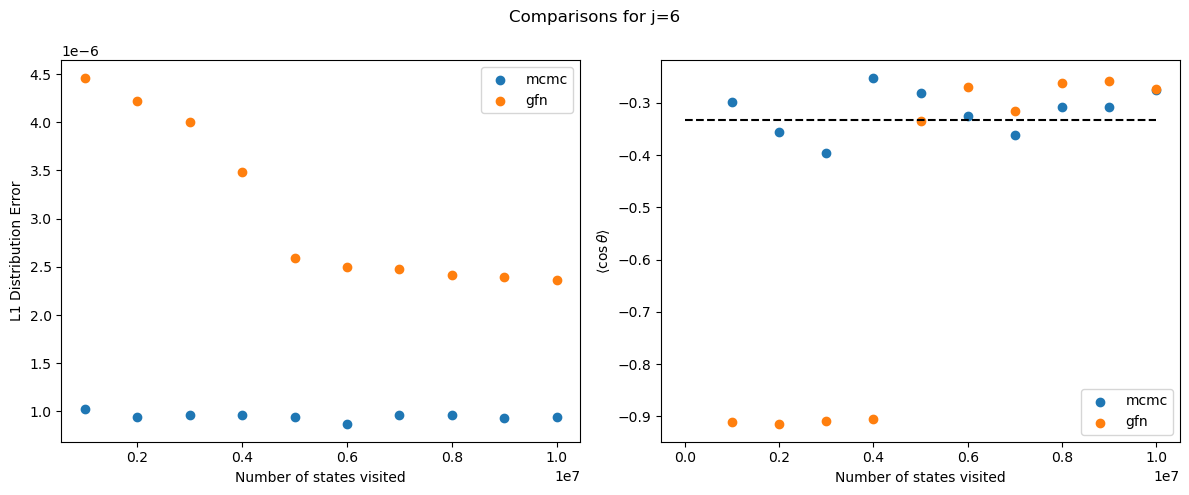

In [20]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

fig.suptitle(f"Comparisons for j={spin_j}")

xs = [int((i+1)*1e6) for i in range(len(mcmc_files))]

ax[0].scatter(xs, mcmc_l1_mean_errors, label="mcmc")
ax[0].scatter(xs, gfn_l1_mean_errors, label="gfn")
ax[0].legend()
ax[0].set_ylabel("L1 Distribution Error")
ax[0].set_xlabel("Number of states visited")

ax[1].scatter(xs, mean_obs_mcmc, label="mcmc")
ax[1].scatter(xs, mean_obs_gfn, label="gfn")
ax[1].legend()
# ax[1].set_ylim(-1, 1)
ax[1].hlines(-0.33333, 1, int(1e7), colors='k', linestyles='dashed')
ax[1].set_ylabel(r"$\langle \cos \theta \rangle$")
ax[1].set_xlabel("Number of states visited")


fig.tight_layout()

In [21]:
fig.savefig("./notebooks/Joseph_plots/test.svg")

In [61]:
import tensorflow as tf

def _count_sampled_grid_coordinates(samples, grid_length, grid_dimension):
    n_samples = tf.shape(samples)[0]
    zeros = tf.zeros(shape=[grid_length] * grid_dimension, dtype=tf.float32)
    updates = tf.ones(shape=[n_samples], dtype=tf.float32)
    counts = tf.tensor_scatter_nd_add(zeros, samples, updates)
    return counts

tf_mcmc_intertwiners = tf.constant(mcmc_intertwiners, dtype=tf.int32)
tf_gfn_intertwiners = tf.constant(gfn_intertwiners, dtype=tf.int32)

In [64]:
def _get_empirical_distributions(intertwiners, grid_length, grid_dimension):
    distributions = []
    for i in range(intertwiners.shape[0]):
        counts = _count_sampled_grid_coordinates(intertwiners[i], grid_length, grid_dimension)
        distribution = counts / tf.reduce_sum(counts)
        distributions.append(distribution)
    return distributions

In [65]:
mcmc_distributions = _get_empirical_distributions(tf_mcmc_intertwiners, 8, 5)
gfn_distributions = _get_empirical_distributions(gfn_intertwiners, 8, 5)

In [66]:
vertex = np.load(f"./data/EPRL_vertices/Python/Dl_20/vertex_j_{spin_j}.npz")

In [69]:
def _get_l1_error(distributions, vertex):
    return [
        np.mean(np.abs(vertex - distribution.numpy()))
        for distribution in distributions
    ]

mcmc_errors = _get_l1_error(mcmc_distributions, vertex)
gfn_errors = _get_l1_error(gfn_distributions, vertex)


In [70]:
mcmc_errors

[3.0517578133975175e-05,
 3.051757811290765e-05,
 3.051757814234178e-05,
 3.051757816243686e-05,
 3.0517578116111975e-05,
 3.0517578184113054e-05,
 3.051757820541366e-05,
 3.0517578193901915e-05,
 3.0517578104209505e-05,
 3.0517578124633302e-05]

In [71]:
gfn_errors

[3.0517578100175206e-05,
 3.0517578102813032e-05,
 3.0517578087264862e-05,
 3.05175780375468e-05,
 3.0517578030762448e-05,
 3.051757801874492e-05,
 3.0517578048257656e-05,
 3.051757808738492e-05,
 3.0517578013380736e-05,
 3.0517578031090053e-05]

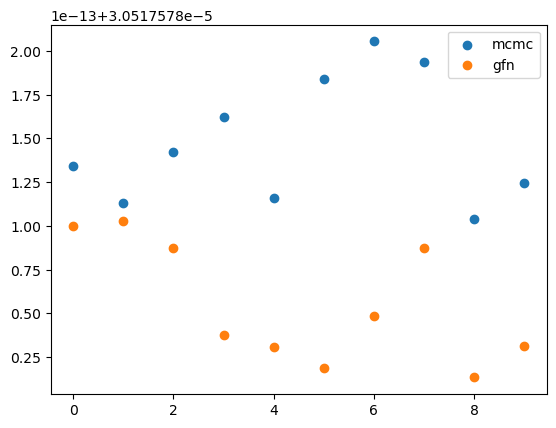

In [75]:
plt.scatter(xs, mcmc_errors, label="mcmc")
plt.scatter(xs, gfn_errors, label="gfn")
plt.legend()
